### Load data

In [ ]:
from src.data.diabetes_datasets.kaggle_bris_t1d.bris_t1d import BrisT1DDataLoader

loader = BrisT1DDataLoader(use_cached=True)
# TODO:TONY - Not sure why it is still processing even if use_cached is True

2025-09-24T16:18:52 - ============================================================
2025-09-24T16:18:52 - Beginning data loading process with the following parmeters:
2025-09-24T16:18:52 - 	Dataset: kaggle_brisT1D - train
2025-09-24T16:18:52 - 	Columns: None
2025-09-24T16:18:52 - 	Generic patient start date: 2024-01-01 00:00:00
2025-09-24T16:18:52 - 	Number of validation days: 20
2025-09-24T16:18:52 - 	In parallel with up to 3 workers.

2025-09-24T16:18:52 - Processed data path for kaggle_brisT1D: /Users/tonychan/GlucoseML/nocturnal-hypo-gly-prob-forecast/cache/data/kaggle_brisT1D/processed
2025-09-24T16:18:52 - cache_manager.load_processed_data() returned dfs for:
 None
2025-09-24T16:18:52 - Processed cache not found or not used, processing raw data and saving to cache...
2025-09-24T16:18:52 - Raw data for kaggle_brisT1D already exists in cache
2025-09-24T16:19:01 - _process_raw_train_data: Processing train data. This may take a while...
2025-09-24T16:19:02 - Processing 9 patients:
202

In [ ]:
BrisT1DDataLoader(use_cached=True)
# TODO:TONY - Not sure why it is still processing even if use_cached is True

In [33]:
import pprint

pprint.pp(loader.patient_ids)
pprint.pp(loader.train_data_shape_summary)

['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p11', 'p12', 'p10']
{'p01': (8711, 14),
 'p02': (26423, 14),
 'p03': (26423, 14),
 'p04': (24983, 14),
 'p05': (8808, 14),
 'p06': (8791, 14),
 'p11': (25559, 14),
 'p12': (26371, 14),
 'p10': (25803, 14)}


## TTM models:
- [Paper](https://arxiv.org/pdf/2401.03955)
- [TTM notes](https://docs.google.com/document/d/1Iw-wMklzsqrucbaQs9JYZ3mpdbp5eN7Cc0I1GVolwXg/edit?tab=t.0)

Some restrictions we have to work with:

| | **Context Lengths** | | | **Forecast Lengths** | | | |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| **Resolution** | **512 (TTM-B)** | **1024 (TTM-E)** | **1526 (TTM-A)** | **96** | **192** | **336** | **720** |
| **1 min** | 512 mins (8.5 hrs) | 1024 mins (17.1 hrs) | 1526 mins (25.4 hrs) | 96 mins (1.6 hrs) | 192 mins (3.2 hrs) | 336 mins (5.6 hrs) | 720 mins (12 hrs) |
| **5 mins** | 2560 mins (42.7 hrs) | 5120 mins (85.3 hrs) | 7630 mins (127.2 hrs) | 480 mins (8 hrs) | 960 mins (16 hrs) | 1680 mins (28 hrs) | 3600 mins (60 hrs) |
| **15 mins** | 7680 mins (128 hrs) | 15360 mins (256 hrs) | 22890 mins (381.5 hrs) | 1440 mins (24 hrs) | 2880 mins (48 hrs) | 5040 mins (84 hrs) | 10800 mins (180 hrs) |

- For 5-min patients: The mininum context length is 42.7 hours and the mininum forecast horizon is 8 hours.
- For 15-min patients: The minumum context length is 128 hours and the mininum forecast horizon is 24 hours.


- 5-minute patients: ['p02', 'p03', 'p04', 'p10', 'p11', 'p12']
- 15-minute patients: ['p01', 'p05', 'p06']


Each patient has 90 days worth of data

| Train | Validation |
| ----  | ----       |
| 70 days | 20 days  |







In [54]:
# Train a general TTM model with all patients (5-min or 15-min)
train_general_ttm_model = False
resolution = 5

# Which specific patient to train if train_general_ttm_model is False
patient_to_train = "p01"


train_dict = loader.train_data
if not train_general_ttm_model:
    resolution = (
        train_dict[patient_to_train].index[1] - train_dict[patient_to_train].index[0]
    ).components.minutes


print(
    "Training general TTM model with resolution: "
    if train_general_ttm_model
    else "Training patient-specific TTM model for patient:",
    patient_to_train,
)
print("Resolution: ", resolution, "minutes")

Training patient-specific TTM model for patient: p01
Resolution:  15 minutes


### Reduce columns and impute missing values on training set

In [55]:
# import pandas as pd
from src.tuning.benchmark import impute_missing_values


def reduce_features(df):
    # Make sure index is set to datetime
    p_df = df.iloc[:]
    # p_df.set_index("datetime", inplace=True)
    # p_df = p_df.asfreq('5T', method='pad') -- Padding is NOT recommended as ttm is not designed for it.

    # Reduce features
    y_feature = ["bg_mM"]
    x_features = [
        "steps",
        "cob",
        "carb_availability",
        "insulin_availability",
        "iob",
    ]
    p_df = p_df[x_features + y_feature]

    # Impute with default methods
    p_df = impute_missing_values(p_df, columns=x_features)
    p_df = impute_missing_values(p_df, columns=y_feature)

    y, X = p_df[y_feature], p_df[x_features]
    return y, X


# TODO:TONY - Just one patient for now.
y_train, X_train = reduce_features(train_dict[patient_to_train])

### Config trainning parameterse and checkpoint

Configure:
1. `batch_size`
2. `dir_path`

This will save a model every x time step.

The model don't support saving every x epochs so we have to calculate that using the batch size and number of steps

The numbers don't match up exactly probably due to some rounding issues.


In [ ]:
from sktime.forecasting.ttm import TinyTimeMixerForecaster
import numpy as np
import pandas as pd

current_time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")

# Shape: (# of patients, # of time steps, # of features)
# loss_callback = LossPlottingCallback()

CONTEXT_LENGTH = 512
FORECAST_LENGTH = 96

# Batch size should be a week, ie (1440 mins / resolution_mins) * 7 timesteps
DAYS_PER_BATCH = 7
BATCH_SIZE = (1440 // resolution) * DAYS_PER_BATCH

EPOCHS = 10

interval = f"{resolution}mins"
dir_path = f"../../models/ttm/{interval}/{current_time}"
if not train_general_ttm_model:
    dir_path = f"../../models/ttm/{interval}/{patient_to_train}/{current_time}"

ttm_forecaster = TinyTimeMixerForecaster(
    model_path="ibm/TTM",
    fit_strategy="full",
    revision="main",  # Main: 512 context length, 96 forecast length
    # class TinyTimeMixerConfig(PretrainedConfig):
    config={
        "context_length": CONTEXT_LENGTH,  # This is the minimum context length
        "prediction_length": FORECAST_LENGTH,  # This is the minimum prediction length
    },
    # https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments
    training_args={
        "num_train_epochs": EPOCHS,  # Update this (1000 is just a placeholder)
        "output_dir": dir_path,
        "use_cpu": False,
        "per_device_train_batch_size": BATCH_SIZE,
        "eval_strategy": "epoch",
        "save_strategy": "epoch",
    },
)

print(f"Selected interval: {interval}")
print(f"Training samples: {len(X_train)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Theoretical steps per epoch: {len(X_train) / BATCH_SIZE}")
print(f"Saving models to: {dir_path}")

# checkpoint-{step}

# Why are we seeing a multiple of 8 steps per epoch? It should be 10

Selected interval: 15mins
Training samples: 6723
Batch size: 672
Epochs: 10
Theoretical steps per epoch: 10.004464285714286
Saving models to: ../../models/ttm/15mins/p01/2025-09-24_17-20-06


### Fit model on training set

In [98]:
fh = np.arange(1, FORECAST_LENGTH + 1)
ttm_forecaster.fit(y=y_train, X=X_train, fh=fh)

TinyTimeMixerForecaster(config={'context_length': 512, 'prediction_length': 96},
                        fit_strategy='full',
                        training_args={'eval_strategy': 'epoch',
                                       'num_train_epochs': 10,
                                       'output_dir': '../../models/ttm/15mins/p01/2025-09-24_17-20-06',
                                       'per_device_train_batch_size': 672,
                                       'save_strategy': 'epoch',
                                       'use_cpu': False})

### Load the model at a given checkpoint and what patient to test
1. Change the model_path and checkpoint
2. Change the patient

The checkpoint number doesn't exactly line up. For example, checkpoint = 9 might give you Epoch number 10.

I think that is because there is some roundinng issue when we calculate the epoch num during saving

In [99]:
# Change these 2 values
model_path = "../../models/ttm/15mins/2025-09-24_16-39-28/checkpoint-80"

# checkpoint = 9
# patient = "p02"

# checkpoint_dirs = []

# dirs = [d for d in os.listdir(model_path) if os.path.isdir(os.path.join(model_path, d))]

# for dir in dirs:
#     if dir.startswith("checkpoint-"):
#         checkpoint_dirs.append(model_path + "/" + dir)

# Sort checkpoints by number
# checkpoint_dirs = sorted(checkpoint_dirs, key=lambda x: int(x.split("-")[-1]))
# print(checkpoint_dirs)

# This ain't working..... The model should have been fitted already
# model_path = "../../src/models/ttm/05mins/2025-03-04_12-02-09/checkpoint-9250"
# model_path = checkpoint_dirs[checkpoint]
# print(len(checkpoint_dirs))
# print("model_path", model_path)

# This is the model we are using
ttm_checkpoint = TinyTimeMixerForecaster(
    model_path=model_path,
    config={
        "context_length": 512,  # or whatever your context length is
        "prediction_length": 96,  # or whatever your prediction length is
    },
)

# Extract checkpoint number from model path
# checkpoint_num = int(model_path.split("-")[-1])
# print(f"Using checkpoint {checkpoint_num}")
# epoch_num = round(checkpoint_num / (steps_per_epoch * SAVE_EVERY_EPOCH))
# print(f"Epoch number: {epoch_num}")

ttm_checkpoint

TinyTimeMixerForecaster(config={'context_length': 512, 'prediction_length': 96},
                        model_path='../../models/ttm/15mins/2025-09-24_16-39-28/checkpoint-80')

### Load the specific patient data

In [100]:
train_df = loader.train_data[patient_to_train]
test_df = loader.validation_data[patient_to_train]

y_train_patient, X_train_patient = reduce_features(train_df)

### Use the modal

1. Use the modeal we just load
2. Load the model directly from a path.

In [ ]:
# 1. Use the modal we just load
forecaster = ttm_checkpoint

# 2, Load the model directly from a path.
# forecaster = TinyTimeMixerForecaster(
#     model_path="../../src/models/ttm/05mins/2025-03-04_12-02-09/checkpoint-9250"
# )


# Fit the model
# forecaster.fit(y=y_train_patient, X=X_train_patient, fh=fh)

TinyTimeMixerForecaster(config={'context_length': 512, 'prediction_length': 96},
                        model_path='../../models/ttm/15mins/2025-09-24_16-39-28/checkpoint-80')

### Evaluate

In [ ]:
# from sktime.split import ExpandingWindowSplitter

# cv = ExpandingWindowSplitter(initial_window=12, step_length=6, fh=fh)
# results = evaluate(forecaster=forecaster, y=y, cv=cv)

### Plot predicted glucose levels

In [72]:
def plot_predicted(ax, forecaster, fh, X_night, test_period):
    predicted_bg = forecaster.predict(fh=fh, X=X_night)
    ax.plot(test_period.index, predicted_bg, label="Predicted glucose levels")


def plot_intervals(ax, forecaster, fh, X_night, test_period):
    pred_int = forecaster.predict_interval(fh=fh, X=X_night, coverage=0.95)[0][0.95]
    ax.plot(
        test_period.index,
        pred_int["upper"],
        label="Predicted upper interval",
        linestyle="--",
    )

    ax.plot(
        test_period.index,
        pred_int["lower"],
        label="Predicted lower interval",
        linestyle="--",
    )


def plot_quantiles(ax, forecaster, fh, X_night, test_period):
    quantiles = [0.95, 0.5, 0.05]
    pred_int = forecaster.predict_quantiles(fh=fh, X=X_night, alpha=quantiles)[
        "bg-0:00"
    ]

    ax.plot(
        test_period.index,
        pred_int[0.05],
        linestyle="--",
        label="0.05 quantile",
    )

    ax.plot(test_period.index, pred_int[0.50], label="0.5 quantile")

    ax.plot(
        test_period.index,
        pred_int[0.95],
        linestyle="--",
        label="0.95 quantile",
    )

AttributeError: 'str' object has no attribute 'iloc'

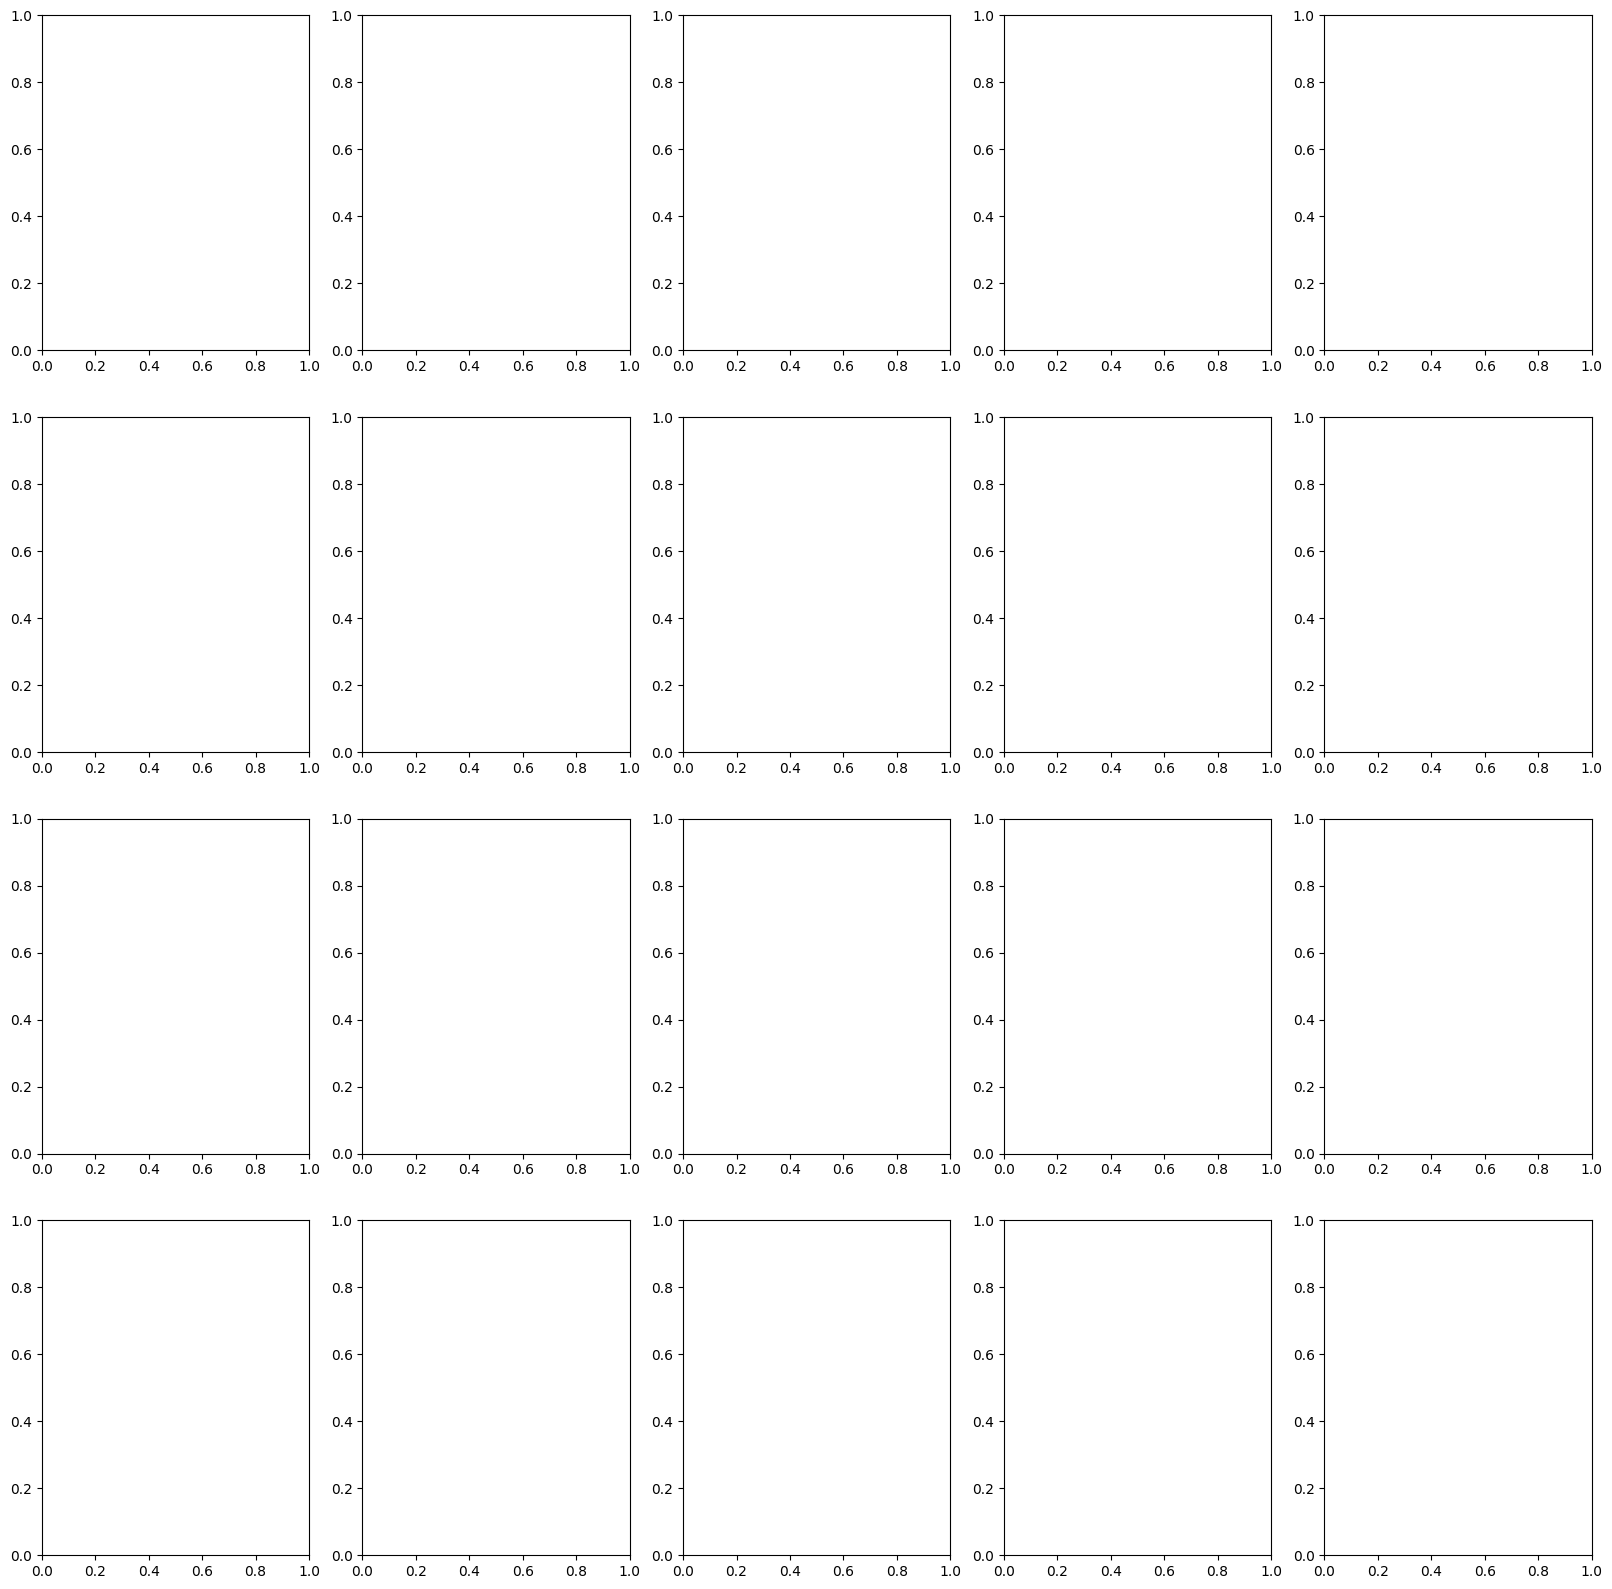

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
# import pandas as pd

# model = "TinyTimeMixerForecaster"
# # Create time index once (288 steps of 5 minutes from 6AM to 6AM next day)
# time_index = pd.date_range(
#     start="2024-01-01 06:00:00", end="2024-01-02 06:00:00", periods=289
# )

# # Create a figure with multiple subplots
# fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 20))
# axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# # Initialize the subplot counter
# subplot_idx = 0
# RMS_ERRORS = np.array([])
# ERRORS_NIGHT = np.array([])

# # Store lines for legend
# legend_lines = []
# legend_labels = []

# # Loop over each day split and create one plot per day
# test_dict = loader.validation_data
# test_df = test_dict[patient_to_train]

# for _, train_period, test_period in test_dict:
#     y_day, X_day = reduce_features(train_period)
#     y_night, X_night = reduce_features(test_period)

#     if X_day.isna().sum().any() > 0:
#         print(X_day)
#     if X_night.isna().sum().any() > 0:
#         print(X_night)

#     # Update the model with the true glucose levels for the day
#     forecaster.update(y=y_day, X=X_day, update_params=False)

#     ######## Determine MSE between predicted and true glucose levels ########
#     predicted_bg = forecaster.predict(fh=fh, X=X_night)

#     ######## Plot true glucose levels ########
#     ax = axes[subplot_idx]
#     daystart = 216 - len(y_day)
#     day_line = ax.plot(
#         time_index[daystart : len(y_day) + daystart],
#         y_day["bg-0:00"],
#         color="skyblue",
#         label="True glucose levels",
#     )[0]
#     night_line = ax.plot(
#         time_index[-72:],
#         y_night["bg-0:00"],
#         color="steelblue",
#         linestyle="-",
#         label="True nocturnal glucose levels",
#     )[0]

#     predicted_bg_ax = ax.plot(
#         time_index[-72:],
#         predicted_bg,
#         color="darkorange",
#         linestyle="-",
#         label="Predicted glucose levels",
#     )[0]

#     # Format x-axis
#     ax.xaxis.set_major_locator(
#         mdates.HourLocator(interval=2)
#     )  # Show ticks every 2 hours
#     ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))  # Format as HH:MM

#     mse = np.sqrt(np.mean((predicted_bg.values - y_night["bg-0:00"].values) ** 2))
#     SE_NIGHT = (predicted_bg.values - y_night["bg-0:00"].values) ** 2
#     ERRORS_NIGHT = np.append(ERRORS_NIGHT, SE_NIGHT)
#     RMS_ERRORS = np.append(RMS_ERRORS, mse)
#     ax.set_title(f"Day: {subplot_idx}, RMSE: {mse:.2f}")

#     ######## Plot predicted glucose levels ########
#     # Only store legend items from first subplot
#     if subplot_idx == 0:
#         legend_lines.extend([day_line, night_line, predicted_bg_ax])
#         legend_labels.extend(
#             [
#                 "True glucose levels",
#                 "True nocturnal glucose levels",
#                 "Predicted glucose levels",
#             ]
#         )

#     # Set limits to show full 24-hour period
#     ax.set_xlim(time_index[0], time_index[-1])

#     # Add labels and formatting for each subplot (remove legend)
#     ax.set_xlabel("Time", fontsize=10)
#     # Hide y-axis labels for all plots except first in each row
#     if subplot_idx % 5 != 0:  # If not first plot in row
#         ax.yaxis.set_ticklabels([])
#     else:
#         ax.set_ylabel("BGL (mmol/L)", fontsize=10)
#     ax.set_ylim(0, 17.5)

#     ax.tick_params(axis="x", rotation=90, labelsize=8)
#     # Add horizontal reference lines
#     ax.axhline(
#         y=3.9, color="crimson", linestyle="--", alpha=0.5
#     )  # Hypoglycemia threshold
#     ax.axhline(
#         y=10.0, color="crimson", linestyle="--", alpha=0.5
#     )  # Hyperglycemia threshold
#     ax.axvline(
#         x=time_index[216], color="black", linestyle=":", alpha=0.5
#     )  # Nocturnal start
#     # Update the model with the true glucose levels for the night
#     # forecaster.update(y=y_night, X=X_night, update_params=False)

#     # Increment the subplot index for the next day
#     subplot_idx += 1

# TOTAL_TEST_RMSE = np.sqrt(np.mean(ERRORS_NIGHT))

# fig.suptitle(
#     f"Point Forecasting of Nocturnal Glucose Levels over 20 days \n {model} (after {epoch_num} epoch), Overall Nocturnal RMSE: {TOTAL_TEST_RMSE:.2f}",
#     fontweight="bold",
#     fontsize=16,
# )

# # Add a single legend outside the subplots
# fig.legend(legend_lines, legend_labels, ncols=3, bbox_to_anchor=(0.65, 0.0))

# # Adjust layout to avoid overlap with the legend
# plt.tight_layout(rect=[0, 0, 0.95, 1], pad=2.0)

# # Show the figure with multiple subplots
# plt.show()


# print(RMS_ERRORS[~np.isnan(RMS_ERRORS)])

# # 4: 2.2
# # 11: 2.21